# RAG Evaluation with Metrics

In [2]:
import os
import sys
import json
import pickle
import numpy as np
from typing import List, Dict, Tuple
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

sys.path.append(os.getcwd())
from src.rag_system import RAGSystem


C:\Users\barni\OneDrive\Работен плот\RAG Tech Support\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
rag = RAGSystem(
    vector_db_path="vector_db",
    model_name="llama3.2:3b" 
)

Loading embedding model...


Loading weights: 100%|██████████| 103/103 [00:00<00:00, 306.68it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


RAG System initialized
  Vector DB: vector_db
  Documents: 82
  Model: llama3.2:3b


In [4]:
test_cases = [
    {
        'id': 'test_001',
        'query': 'How do I install CloudSync Pro on Windows?',
        'relevant_products': ['CloudSync Pro'],
        'relevant_categories': ['installation'],
        'expected_answer_contains': ['download', 'install', 'windows']
    },
    {
        'id': 'test_002',
        'query': 'My files are not syncing in CloudSync Pro',
        'relevant_products': ['CloudSync Pro'],
        'relevant_categories': ['troubleshooting'],
        'expected_answer_contains': ['sync', 'internet', 'connection']
    },
    {
        'id': 'test_003',
        'query': 'What is selective sync feature?',
        'relevant_products': ['CloudSync Pro'],
        'relevant_categories': ['features'],
        'expected_answer_contains': ['selective', 'sync', 'folders']
    },
    {
        'id': 'test_004',
        'query': 'How to backup files with DataVault?',
        'relevant_products': ['DataVault'],
        'relevant_categories': ['features', 'installation'],
        'expected_answer_contains': ['backup', 'files']
    },
    {
        'id': 'test_005',
        'query': 'DataVault backup is failing',
        'relevant_products': ['DataVault'],
        'relevant_categories': ['troubleshooting'],
        'expected_answer_contains': ['backup', 'disk space', 'destination']
    },
    {
        'id': 'test_006',
        'query': 'TeamChat video call quality is bad',
        'relevant_products': ['TeamChat'],
        'relevant_categories': ['troubleshooting'],
        'expected_answer_contains': ['video', 'internet', 'connection']
    },
    {
        'id': 'test_007',
        'query': 'How to send messages in TeamChat?',
        'relevant_products': ['TeamChat'],
        'relevant_categories': ['features'],
        'expected_answer_contains': ['message', 'channel']
    },
    {
        'id': 'test_008',
        'query': 'Cannot create new project in ProjectHub',
        'relevant_products': ['ProjectHub'],
        'relevant_categories': ['troubleshooting'],
        'expected_answer_contains': ['project', 'limit', 'permission']
    },
    {
        'id': 'test_009',
        'query': 'What is Kanban board in ProjectHub?',
        'relevant_products': ['ProjectHub'],
        'relevant_categories': ['features'],
        'expected_answer_contains': ['kanban', 'board', 'task']
    },
    {
        'id': 'test_010',
        'query': 'How much storage do I get with CloudSync Pro?',
        'relevant_products': ['CloudSync Pro'],
        'relevant_categories': ['faq'],
        'expected_answer_contains': ['storage', 'gb', 'pro']
    },
    {
        'id': 'test_011',
        'query': 'Is TeamChat available on mobile?',
        'relevant_products': ['TeamChat'],
        'relevant_categories': ['faq'],
        'expected_answer_contains': ['mobile', 'ios', 'android']
    },
    {
        'id': 'test_012',
        'query': 'How secure are DataVault backups?',
        'relevant_products': ['DataVault'],
        'relevant_categories': ['faq'],
        'expected_answer_contains': ['secure', 'encrypt', 'aes']
    },
]

In [5]:
def is_relevant_result(retrieved_metadata: Dict, test_case: Dict) -> bool:
    """
    Check if retrieved document is relevant for test case
    
    Args:
        retrieved_metadata: Metadata for retrieved document
        test_case: Test case with relevant_products and relevant_categories
    
    Returns:
        True if document is relevant
    """
    product_match = retrieved_metadata['product'] in test_case['relevant_products']
    category_match = retrieved_metadata['category'] in test_case['relevant_categories']
    
    return product_match and category_match


def calculate_precision_at_k(retrieved_metadatas: List[Dict], test_case: Dict, k: int) -> float:
    """
    Precision@K: What % of top K documents are relevant?
    
    Formula: (# relevant docs in top K) / K
    """
    top_k = retrieved_metadatas[:k]
    relevant_count = sum(1 for meta in top_k if is_relevant_result(meta, test_case))
    return relevant_count / k if k > 0 else 0


def calculate_recall_at_k(retrieved_metadatas: List[Dict], test_case: Dict, k: int, total_relevant: int) -> float:
    """
    Recall@K: What % of all relevant documents are found?
    
    Formula: (# relevant docs retrieved) / (total # relevant docs)
    """
    top_k = retrieved_metadatas[:k]
    found_count = sum(1 for meta in top_k if is_relevant_result(meta, test_case))
    return found_count / total_relevant if total_relevant > 0 else 0


def calculate_hit_rate(retrieved_metadatas: List[Dict], test_case: Dict, k: int) -> float:
    """
    Hit Rate: If one relevant document is found?
    
    Returns 1.0 if yes, 0.0 if no
    """
    top_k = retrieved_metadatas[:k]
    for meta in top_k:
        if is_relevant_result(meta, test_case):
            return 1.0
    return 0.0


def calculate_mrr(retrieved_metadatas: List[Dict], test_case: Dict) -> float:
    """
    MRR (Mean Reciprocal Rank): Position of the first relevant document?
    
    Returns 1/rank (so higher rank = better score)
    Example: First relevant at position 2 → MRR = 1/2 = 0.5
    """
    for rank, meta in enumerate(retrieved_metadatas, start=1):
        if is_relevant_result(meta, test_case):
            return 1.0 / rank
    return 0.0 


print("Evaluation functions created!")

Evaluation functions created!


In [6]:
K_VALUES = [1, 3, 5] 
TOTAL_RELEVANT_DOCS = 5

evaluation_results = []

print("Running evaluation...\n")
print("="*80)

for test_case in tqdm(test_cases, desc="Evaluating test cases"):
    query = test_case['query']
    
    search_results = rag.search(query, n_results=max(K_VALUES))
    retrieved_metadatas = search_results['metadatas']
    distances = search_results['distances']
    
    result = {
        'test_id': test_case['id'],
        'query': query,
        'relevant_products': test_case['relevant_products'],
        'relevant_categories': test_case['relevant_categories'],
    }
    
    for k in K_VALUES:
        precision = calculate_precision_at_k(retrieved_metadatas, test_case, k)
        recall = calculate_recall_at_k(retrieved_metadatas, test_case, k, TOTAL_RELEVANT_DOCS)
        hit_rate = calculate_hit_rate(retrieved_metadatas, test_case, k)
        
        result[f'precision@{k}'] = precision
        result[f'recall@{k}'] = recall
        result[f'hit_rate@{k}'] = hit_rate
    
    result['mrr'] = calculate_mrr(retrieved_metadatas, test_case)
    
    result['top_3_results'] = [
        {
            'product': meta['product'],
            'category': meta['category'],
            'title': meta['title'],
            'distance': dist
        }
        for meta, dist in zip(retrieved_metadatas[:3], distances[:3])
    ]
    
    evaluation_results.append(result)

print("\n Evaluation complete!")

Running evaluation...



Evaluating test cases: 100%|██████████| 12/12 [00:00<00:00, 36.27it/s]


 Evaluation complete!


In [8]:
print("Sample Evaluation Results:\n")
print("="*80)

for i, result in enumerate(evaluation_results[:3], 1):
    print(f"\nTest {i}: {result['test_id']}")
    print(f"Query: {result['query']}")
    print(f"Expected: {result['relevant_products']} - {result['relevant_categories']}")
    print(f"\nMetrics:")
    print(f"  Precision@3: {result['precision@3']:.2f}")
    print(f"  Recall@3: {result['recall@3']:.2f}")
    print(f"  Hit Rate@3: {result['hit_rate@3']:.2f}")
    print(f"  MRR: {result['mrr']:.3f}")
    
    print(f"\nTop 3 Retrieved:")
    for j, doc in enumerate(result['top_3_results'], 1):
        relevant = "✓" if (doc['product'] in result['relevant_products'] and 
                          doc['category'] in result['relevant_categories']) else "✗"
        print(f"  {j}. {relevant} {doc['product']} - {doc['category']} (dist: {doc['distance']:.4f})")
    print("-"*80)

Sample Evaluation Results:


Test 1: test_001
Query: How do I install CloudSync Pro on Windows?
Expected: ['CloudSync Pro'] - ['installation']

Metrics:
  Precision@3: 1.00
  Recall@3: 0.60
  Hit Rate@3: 1.00
  MRR: 1.000

Top 3 Retrieved:
  1. ✓ CloudSync Pro - installation (dist: 0.2742)
  2. ✓ CloudSync Pro - installation (dist: 0.2804)
  3. ✓ CloudSync Pro - installation (dist: 0.2804)
--------------------------------------------------------------------------------

Test 2: test_002
Query: My files are not syncing in CloudSync Pro
Expected: ['CloudSync Pro'] - ['troubleshooting']

Metrics:
  Precision@3: 1.00
  Recall@3: 0.60
  Hit Rate@3: 1.00
  MRR: 1.000

Top 3 Retrieved:
  1. ✓ CloudSync Pro - troubleshooting (dist: 0.5687)
  2. ✓ CloudSync Pro - troubleshooting (dist: 0.6950)
  3. ✓ CloudSync Pro - troubleshooting (dist: 0.7277)
--------------------------------------------------------------------------------

Test 3: test_003
Query: What is selective sync feature?
Expected: ['

In [9]:
def calculate_average_metrics(results: List[Dict]) -> Dict:
    """Calculate average values"""
    avg_metrics = {}
    
    for k in K_VALUES:
        avg_metrics[f'precision@{k}'] = np.mean([r[f'precision@{k}'] for r in results])
        avg_metrics[f'recall@{k}'] = np.mean([r[f'recall@{k}'] for r in results])
        avg_metrics[f'hit_rate@{k}'] = np.mean([r[f'hit_rate@{k}'] for r in results])
    
    avg_metrics['mrr'] = np.mean([r['mrr'] for r in results])
    
    return avg_metrics

avg_metrics = calculate_average_metrics(evaluation_results)

print("\n" + "="*80)
print("OVERALL EVALUATION METRICS")
print("="*80)
print()

for k in K_VALUES:
    print(f"K = {k}:")
    print(f"  Precision@{k}: {avg_metrics[f'precision@{k}']:.3f}")
    print(f"  Recall@{k}:    {avg_metrics[f'recall@{k}']:.3f}")
    print(f"  Hit Rate@{k}:  {avg_metrics[f'hit_rate@{k}']:.3f}")
    print()

print(f"MRR (Mean Reciprocal Rank): {avg_metrics['mrr']:.3f}")
print("\n" + "="*80)


OVERALL EVALUATION METRICS

K = 1:
  Precision@1: 0.917
  Recall@1:    0.183
  Hit Rate@1:  0.917

K = 3:
  Precision@3: 0.528
  Recall@3:    0.317
  Hit Rate@3:  0.917

K = 5:
  Precision@5: 0.417
  Recall@5:    0.417
  Hit Rate@5:  0.917

MRR (Mean Reciprocal Rank): 0.917



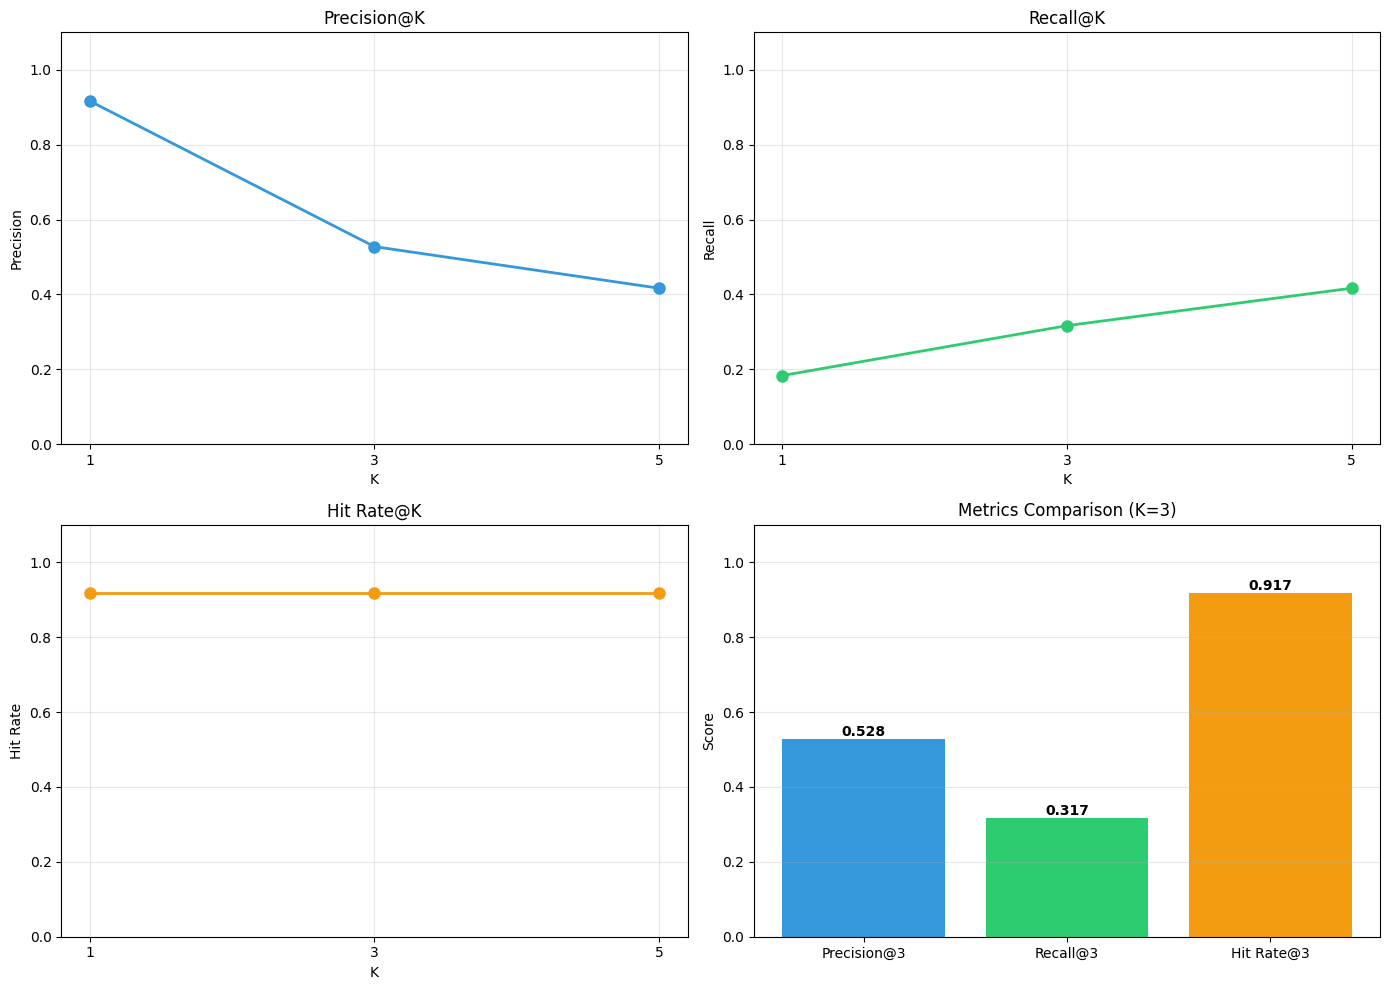

Visualization saved to data/processed/evaluation_metrics.png


In [10]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

precision_values = [avg_metrics[f'precision@{k}'] for k in K_VALUES]
axes[0, 0].plot(K_VALUES, precision_values, marker='o', linewidth=2, markersize=8, color='#3498db')
axes[0, 0].set_xlabel('K')
axes[0, 0].set_ylabel('Precision')
axes[0, 0].set_title('Precision@K')
axes[0, 0].set_ylim(0, 1.1)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks(K_VALUES)

recall_values = [avg_metrics[f'recall@{k}'] for k in K_VALUES]
axes[0, 1].plot(K_VALUES, recall_values, marker='o', linewidth=2, markersize=8, color='#2ecc71')
axes[0, 1].set_xlabel('K')
axes[0, 1].set_ylabel('Recall')
axes[0, 1].set_title('Recall@K')
axes[0, 1].set_ylim(0, 1.1)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xticks(K_VALUES)

hit_rate_values = [avg_metrics[f'hit_rate@{k}'] for k in K_VALUES]
axes[1, 0].plot(K_VALUES, hit_rate_values, marker='o', linewidth=2, markersize=8, color='#f39c12')
axes[1, 0].set_xlabel('K')
axes[1, 0].set_ylabel('Hit Rate')
axes[1, 0].set_title('Hit Rate@K')
axes[1, 0].set_ylim(0, 1.1)
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xticks(K_VALUES)

metrics_k3 = ['Precision@3', 'Recall@3', 'Hit Rate@3']
values_k3 = [
    avg_metrics['precision@3'],
    avg_metrics['recall@3'],
    avg_metrics['hit_rate@3']
]
colors = ['#3498db', '#2ecc71', '#f39c12']
bars = axes[1, 1].bar(metrics_k3, values_k3, color=colors)
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('Metrics Comparison (K=3)')
axes[1, 1].set_ylim(0, 1.1)
axes[1, 1].grid(axis='y', alpha=0.3)

for bar, value in zip(bars, values_k3):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{value:.3f}',
                    ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('data/processed/evaluation_metrics.png', dpi=150, bbox_inches='tight')
plt.show()

print("Visualization saved to data/processed/evaluation_metrics.png")

In [11]:
product_metrics = {}

for product in ['CloudSync Pro', 'DataVault', 'TeamChat', 'ProjectHub']:
    product_results = [
        r for r in evaluation_results 
        if product in r['relevant_products']
    ]
    
    if product_results:
        product_metrics[product] = calculate_average_metrics(product_results)

print("\nPerformance by Product (K=3):\n")
print("="*80)

for product, metrics in product_metrics.items():
    print(f"\n{product}:")
    print(f"  Precision@3: {metrics['precision@3']:.3f}")
    print(f"  Recall@3:    {metrics['recall@3']:.3f}")
    print(f"  Hit Rate@3:  {metrics['hit_rate@3']:.3f}")
    print(f"  MRR:         {metrics['mrr']:.3f}")

print("\n" + "="*80)


Performance by Product (K=3):


CloudSync Pro:
  Precision@3: 0.583
  Recall@3:    0.350
  Hit Rate@3:  0.750
  MRR:         0.750

DataVault:
  Precision@3: 0.556
  Recall@3:    0.333
  Hit Rate@3:  1.000
  MRR:         1.000

TeamChat:
  Precision@3: 0.444
  Recall@3:    0.267
  Hit Rate@3:  1.000
  MRR:         1.000

ProjectHub:
  Precision@3: 0.500
  Recall@3:    0.300
  Hit Rate@3:  1.000
  MRR:         1.000



In [12]:
os.makedirs('data/processed', exist_ok=True)

with open('data/processed/evaluation_results.json', 'w', encoding='utf-8') as f:
    json.dump(evaluation_results, f, indent=2, ensure_ascii=False)

print("Detailed results saved to data/processed/evaluation_results.json")

summary = {
    'overall_metrics': avg_metrics,
    'product_metrics': product_metrics,
    'total_test_cases': len(test_cases),
    'k_values': K_VALUES
}

with open('data/processed/evaluation_summary.json', 'w', encoding='utf-8') as f:
    json.dump(summary, f, indent=2, ensure_ascii=False)

print("Summary saved to data/processed/evaluation_summary.json")

Detailed results saved to data/processed/evaluation_results.json
Summary saved to data/processed/evaluation_summary.json


In [13]:
evaluator_code = '''"""RAG Evaluation Functions"""

import numpy as np
from typing import List, Dict

def is_relevant_result(retrieved_metadata: Dict, test_case: Dict) -> bool:
    """Check if retrieved document is relevant"""
    product_match = retrieved_metadata['product'] in test_case['relevant_products']
    category_match = retrieved_metadata['category'] in test_case['relevant_categories']
    return product_match and category_match

def calculate_precision_at_k(retrieved_metadatas: List[Dict], test_case: Dict, k: int) -> float:
    """Precision@K: (# relevant in top K) / K"""
    top_k = retrieved_metadatas[:k]
    relevant_count = sum(1 for meta in top_k if is_relevant_result(meta, test_case))
    return relevant_count / k if k > 0 else 0

def calculate_recall_at_k(retrieved_metadatas: List[Dict], test_case: Dict, k: int, total_relevant: int) -> float:
    """Recall@K: (# relevant retrieved) / (total relevant)"""
    top_k = retrieved_metadatas[:k]
    found_count = sum(1 for meta in top_k if is_relevant_result(meta, test_case))
    return found_count / total_relevant if total_relevant > 0 else 0

def calculate_hit_rate(retrieved_metadatas: List[Dict], test_case: Dict, k: int) -> float:
    """Hit Rate: Found at least one relevant doc?"""
    top_k = retrieved_metadatas[:k]
    for meta in top_k:
        if is_relevant_result(meta, test_case):
            return 1.0
    return 0.0

def calculate_mrr(retrieved_metadatas: List[Dict], test_case: Dict) -> float:
    """MRR: 1 / (rank of first relevant doc)"""
    for rank, meta in enumerate(retrieved_metadatas, start=1):
        if is_relevant_result(meta, test_case):
            return 1.0 / rank
    return 0.0

def evaluate_rag_system(rag_system, test_cases: List[Dict], k_values: List[int] = [1, 3, 5]) -> Dict:
    """Run full evaluation"""
    results = []
    
    for test_case in test_cases:
        query = test_case['query']
        search_results = rag_system.search(query, n_results=max(k_values))
        retrieved_metadatas = search_results['metadatas']
        
        result = {
            'test_id': test_case['id'],
            'query': query,
        }
        
        for k in k_values:
            result[f'precision@{k}'] = calculate_precision_at_k(retrieved_metadatas, test_case, k)
            result[f'recall@{k}'] = calculate_recall_at_k(retrieved_metadatas, test_case, k, 5)
            result[f'hit_rate@{k}'] = calculate_hit_rate(retrieved_metadatas, test_case, k)
        
        result['mrr'] = calculate_mrr(retrieved_metadatas, test_case)
        results.append(result)
    
    # Calculate averages
    avg_metrics = {}
    for k in k_values:
        avg_metrics[f'precision@{k}'] = np.mean([r[f'precision@{k}'] for r in results])
        avg_metrics[f'recall@{k}'] = np.mean([r[f'recall@{k}'] for r in results])
        avg_metrics[f'hit_rate@{k}'] = np.mean([r[f'hit_rate@{k}'] for r in results])
    avg_metrics['mrr'] = np.mean([r['mrr'] for r in results])
    
    return {
        'detailed_results': results,
        'average_metrics': avg_metrics
    }
'''

with open('src/evaluator.py', 'w', encoding='utf-8') as f:
    f.write(evaluator_code)

print("Evaluator functions saved to src/evaluator.py")

Evaluator functions saved to src/evaluator.py
